# TODO
https://medium.com/voice-tech-podcast/text-classification-using-cnn-9ade8155dfb9

https://towardsdatascience.com/deciding-optimal-filter-size-for-cnns-d6f7b56f9363

# Neural Networks: CNN

The work of this notebook is based on the paper from Jain et al. [1][2]. A CNN is trained using semantically enriched vectors (using Word2Vec).


[1] Gauri Jain, Manisha Sharma, and Basant Agarwal. Spam detection on social media using semantic convolutional neural network. *International Journal of Knowledge Discovery inBioinformatics (IJKDB)*, 8(1):12–26, 2018.

[2] Gauri Jain, Manisha Sharma, and Basant Agarwal. Spam detection in social media using convolutional and long short term memory neural network. *Annals of Mathematics andArtificial Intelligence*, 85(1):21–44, 2019

In [53]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv1D, Dense, Dropout, Flatten, Input, MaxPooling1D
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split

In [54]:
def plot_metrics(history, validation=False):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_figwidth(12)
    # Accuracy
    ax1.set_title('Model accuracy')
    ax1.set_ylabel('Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.plot(history['accuracy'])
    if validation:
        ax1.plot(history['val_accuracy'])
    ax1.legend(['Train', 'Validation'], loc='upper left')

    # Loss
    ax2.set_title('Model loss') 
    ax2.set_ylabel('Loss') 
    ax2.set_xlabel('Epoch')
    ax2.plot(history['loss'])
    if validation:
        ax2.plot(history['val_loss'])
    ax2.legend(['Train', 'Validation'], loc='upper left') 

    plt.show()

# Data loading and vectorization

In [2]:
full_filepath = "/Users/ppanero/Workspace/zenodo/zenodo-spam-classifier/zenodo_open_metadata_2020-10-19_processed.jsonl"
full_df = pd.read_json(full_filepath, lines=True)  # The file is JSONLines
full_df = full_df.set_index('recid')

In [3]:
full_df.head()

,access_right,spam,num_keywords,num_files,has_image,num_communities,num_creators,creator_has_orcid,creator_has_affiliation,type,type_full,num_words_title,num_words_description,text,has_license
recid,,,,,,,,,,,,,,,
3900603,open,False,0,3,False,1,1,True,True,software,software-None,4,100,the geodynamic world builder the geodynamic w...,other
3363990,open,False,6,5,False,0,3,True,True,publication,publication-article,30,75,alignment ambiguous characters indel maximum l...,CC-BY-4.0
3363503,open,False,8,1,True,1,7,False,False,image,image-figure,24,75,biodiversity taxonomy animalia arthropoda inse...,notspecified
3363619,open,False,8,1,True,1,1,False,False,image,image-figure,21,50,biodiversity taxonomy animalia arthropoda maxi...,notspecified
3363729,closed,False,7,0,False,1,3,False,False,publication,publication-article,14,30,biodiversity taxonomy animalia arthropoda inse...,no-license


In [27]:
# Split dataset
labels = full_df['spam']
data = full_df["text"]
X_train_orig, X_test_orig, y_train, y_test = train_test_split(data, labels, test_size=0.9, random_state=422)
X_train_orig, X_val_orig, y_train, y_val = train_test_split(X_train_orig, y_train, test_size=0.1, random_state=422)

In [28]:
num_features = 8000

In [29]:
# Vectorize text input
tfidf = TfidfVectorizer(max_features=num_features, ngram_range=(4, 5), analyzer='word', stop_words='english')

In [30]:
X_train_vec = tfidf.fit_transform(X_train_orig).todense()
X_val_vec = tfidf.fit_transform(X_val_orig).todense()
# X_test_vec = tfidf.transform(X_test_orig).todense()

In [31]:
print(f"Original training set shape {X_train_vec.shape}")
print(f"Original validation set shape {X_val_vec.shape}")
print(f"Original test set shape {X_test_vec.shape}")

Original training set shape (155007, 8000)
Original validation set shape (17223, 8000)
Original test set shape (172231, 8000)


In [32]:
X_train = np.asarray(X_train_vec).reshape((len(X_train_vec), num_features, 1))
X_val = np.asarray(X_val_vec).reshape(len(X_val_vec), num_features, 1)
# X_test = np.asarray(X_test_vec).reshape(len(X_test_vec), num_features, 1)

In [33]:
print(f"Training set shape {X_train.shape}")
print(f"Validation set shape {X_val.shape}")
print(f"Test set shape {X_test.shape}")

Training set shape (155007, 8000, 1)
Validation set shape (17223, 8000, 1)
Test set shape (172231, 8000, 1)


In [34]:
num_classes = 2  # Number of target classes (Spam and Ham)

In [35]:
print(f"Training labels set size {y_train.shape}")
print(f"Validation labels set size {y_val.shape}")
print(f"Test labels set size {y_test.shape}")

Training labels set size (155007,)
Validation labels set size (17223,)
Test labels set size (1550075,)


An example basic model that would work with the original vectorized dataset:

``` python
example_model = Sequential()
example_model.add(Dense(num_features, input_shape= (num_features,), activation="relu"))
example_model.add(Dense(num_features/2,activation="relu"))
example_model.add(Dense(num_features/4, activation="relu"))
example_model.add(Dropout(0.25))
example_model.add(Dense(num_classes, activation="softmax"))
example_model.compile(optimizer="adagrad", loss='binary_crossentropy', metrics=['accuracy'])
```

However, it would require to transfor the `SparseTensor` into an "array" understanble by the model:

``` python
X_train = X_train.todense()
X_test = X_test.todense()
```

# CNN

From the paper of Jain et al. the hyperparameters are:

- Number of filters: 128
- Filter length: 5
- Droput: 0.1
- Optimizer: Adagrad (default learning rate, 0.1)
- Activation function: ReLu
- Epochs: 10

In [44]:
cnn_model = Sequential()

# Strides is redundant since default is 1. Added for clarity.
cnn_model.add(Conv1D(filters=128, kernel_size=5, input_shape=(num_features, 1), activation="relu"))
cnn_model.add(Dropout(rate=0.1))
cnn_model.add(Flatten())
cnn_model.add(Dense(units=num_classes, activation="softmax"))

Two classes (True-False) make a binary classification, therefore the loss function is `binary_crossentropy`).

In [45]:
cnn_model.compile(optimizer="adagrad", loss='binary_crossentropy', metrics=['accuracy'])

In [46]:
batch_size = 128

In [47]:
history = cnn_model.fit(
    X_train,
    y_train,
    batch_size=batch_size,
    epochs=10,
    validation_data=(X_val, y_val)
)

Epoch 1/10
1211/1211 [==============================] - 1317s 1s/step - loss: 0.6932 - accuracy: 0.7391 - val_loss: 0.6931 - val_accuracy: 0.8848
Epoch 2/10
1211/1211 [==============================] - 1271s 1s/step - loss: 0.6932 - accuracy: 0.7476 - val_loss: 0.6931 - val_accuracy: 0.8848
Epoch 3/10
1211/1211 [==============================] - 1202s 993ms/step - loss: 0.6932 - accuracy: 0.7493 - val_loss: 0.6931 - val_accuracy: 0.8829
Epoch 4/10
1211/1211 [==============================] - 1212s 1s/step - loss: 0.6932 - accuracy: 0.7511 - val_loss: 0.6931 - val_accuracy: 0.8804
Epoch 5/10
1211/1211 [==============================] - 1210s 999ms/step - loss: 0.6932 - accuracy: 0.7518 - val_loss: 0.6931 - val_accuracy: 0.8793
Epoch 6/10
1211/1211 [==============================] - 1211s 1s/step - loss: 0.6932 - accuracy: 0.7537 - val_loss: 0.6931 - val_accuracy: 0.8760
Epoch 7/10
1211/1211 [==============================] - 1211s 1s/step - loss: 0.6932 - accuracy: 0.7551 - val_loss: 0.

In [48]:
cnn_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_5 (Conv1D)            (None, 7996, 128)         768       
_________________________________________________________________
dropout_5 (Dropout)          (None, 7996, 128)         0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 1023488)           0         
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 2046978   
Total params: 2,047,746
Trainable params: 2,047,746
Non-trainable params: 0
_________________________________________________________________


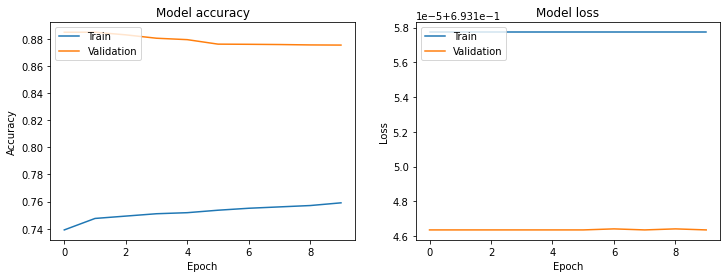

In [55]:
plot_metrics(history.history, validation=True)

In [52]:
# Save model
models_path = "/Users/ppanero/Workspace/zenodo/zenodo-spam-classifier/models/"
cnn_model.save(f"{models_path}/2020_11_05_cnn")

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /Users/ppanero/Workspace/zenodo/zenodo-spam-classifier/models//2020_11_05_cnn/assets


In [51]:
y_train_predclass = cnn_model.predict_classes(X_train, batch_size=batch_size)

train_accuracy = round(accuracy_score(y_train, y_train_predclass), 3)
print(f"Train accuracy: {train_accuracy}")

print("Train Classification Report")
print(classification_report(y_train, y_train_predclass))

Train accuracy: 0.751
Train Classification Report
              precision    recall  f1-score   support

       False       0.98      0.76      0.86    151606
        True       0.02      0.25      0.04      3401

    accuracy                           0.75    155007
   macro avg       0.50      0.51      0.45    155007
weighted avg       0.96      0.75      0.84    155007



In [ ]:
y_test_predclass = cnn_model.predict_classes(X_test, batch_size=batch_size)

test_accuracy = round(accuracy_score(y_test, y_test_predclass), 3)
print(f"Test accuracy: {test_accuracy}")

print("Test Classification Report")
print (classification_report(y_test,y_test_predclass))